Radius (r): 9.742360096347989
Center (x, y): (106.0, 255.0)


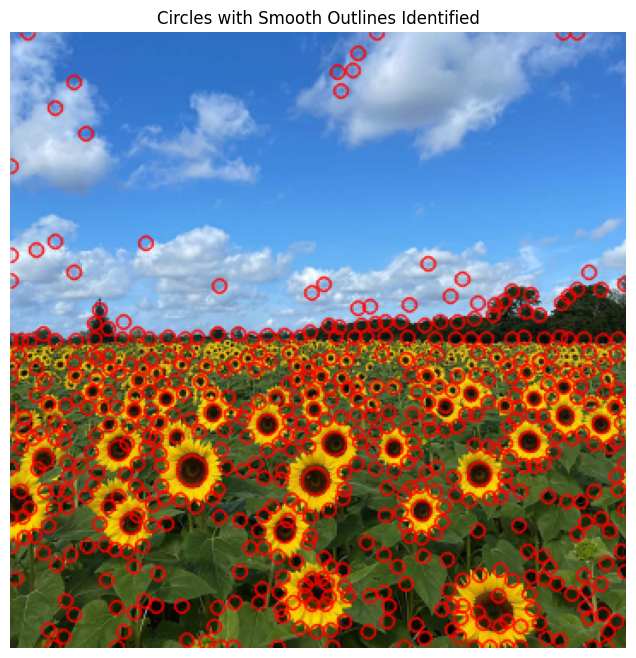

In [9]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from math import sqrt

# Read the image
image = cv.imread('D:/MySem5/ImagePro/Image-Processing-and-Machine-Vision-Tasks/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
Blurred = cv.GaussianBlur(gray, (9,9), 0.1)
Laplc = cv.Laplacian(Blurred, cv.CV_64F)


# Define parameters for blob detection
min_sigma = 3
max_sigma = 10
threshold = 4

# Detect blobs using Laplacian of Gaussians
blobs = blob_log(Laplc, min_sigma=min_sigma,max_sigma=max_sigma, threshold=threshold)
# blobs=blob_log(laplacian, min_sigma=1, max_sigma=30, threshold=0.1, overlap=0.01, log_scale=False)

blobs[:, 2] = blobs[:, 2] * sqrt(2)

max_radius_index = np.argmax(blobs[:, 2])
largest_circle_params = blobs[max_radius_index]
y, x, r = largest_circle_params
print(f"Radius (r): {r}")
print(f"Center (x, y): ({x}, {y})")

# Draw circles on the original grayscale image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(image, (int(x), int(y)), int(r), (0,0,255),thickness=1, lineType=cv.LINE_AA)  # Draw circles in white

# Display the result

# cv.imshow('Detected Circles', gray_three_channel)
# cv.waitKey(0)
# cv.destroyAllWindows()

plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Circles with Smooth Outlines Identified')
plt.show()

--------------------------------------implementing RANSAC Line---------------------------------

iteration 95
line_best_error 13.766043915229865
best_line_indices [93 56]
best_line_model [0.71749034 0.69656845 1.60222554]
no of inliers 44

--------------------------------------implementing RANSAC Circle---------------------------------


no of elements in X 100
no of inliers 44
remnants 56

iteration 0
best_error 8.143586879889565
best_indecies [ 7 50 38]
best_model [ 2.34931216  2.57648939 10.13858581]
no of inliers 38

iteration 28
best_error 6.506878394468667
best_indecies [ 6 30 12]
best_model [ 1.94187705  2.63699071 10.13824311]
no of inliers 39


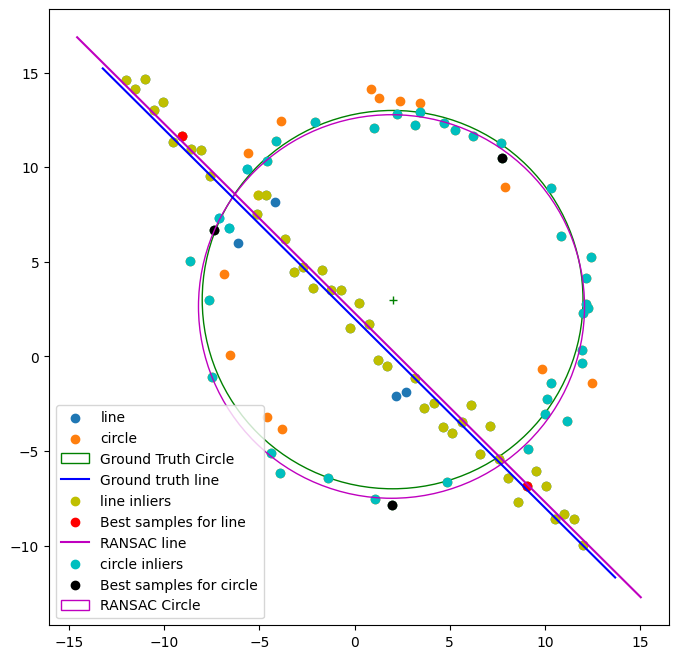

In [12]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# Generate a Noisy Point Set Conforming to a Line and a Circle
# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='circle')
circle_get = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_get)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='b', label='Ground truth line')
plt.legend()

# Implementing RANSAC Line

N = X.shape[0]  # number of points
X = X  # data matrix

print('--------------------------------------implementing RANSAC Line---------------------------------')

# Total least square error for line
def line_total_error(x, line_indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a * X[line_indices, 0] + b * X[line_indices, 1] - d))

# Constraint
def cons(x):
    return x[0]**2 + x[1]**2 - 1

constraint = ({'type': 'eq', 'fun': cons})

# Consensus set
def line_consensus_set(X, x, line_threshold):
    a, b, d = x[0], x[1], x[2]
    error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return error < line_threshold

line_max_iteration = 100
line_threshold = 1.
line_data_points = 0.4 * N
line_best_error = np.inf
line_sample = 2

best_line_indices = []
best_line_model = []
line_inlinears = []
best_line_inliers = []
line_iteration = 0

while line_iteration < line_max_iteration:
    line_indices = np.random.randint(0, N, line_sample)  # randomly select s points
    x0 = np.array([1, 1, 0])  # initial guess
    res = minimize(line_total_error, x0=x0, args=(line_indices), tol=1e-6, constraints=constraint)  # minimize the error
    line_inlinears = line_consensus_set(X, res.x, line_threshold)  # find the consensus set
    if np.sum(line_inlinears) > line_data_points:
        x0 = res.x
        res = minimize(line_total_error, x0=x0, args=(line_inlinears), tol=1e-6, constraints=constraint)  # refit the model
        if res.fun < line_best_error:
            print('\niteration', line_iteration)
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inlinears
            print('line_best_error', line_best_error)
            print('best_line_indices', best_line_indices)
            print('best_line_model', best_line_model)
            print('no of inliers', np.sum(best_line_inliers))

    line_iteration += 1

ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='y', label='line inliers')
ax.scatter(X[best_line_indices, 0], X[best_line_indices, 1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1] * x_ + best_line_model[2]) / best_line_model[1]
plt.plot(x_, y_, color='m', label='RANSAC line')
ax.legend()

# Implementing RANSAC Circle

print('\n--------------------------------------implementing RANSAC Circle---------------------------------')
print('\n')
print('no of elements in X', len(X))
print('no of inliers', np.sum(best_line_inliers))

line_outliers = np.where(best_line_inliers == False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('remnants', len(remnants))

def circle_tls(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

def circle_consenus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    # Count number of inliers
    return distances < circle_threshold

circle_threshold = 1.
max_circle_iterations = 100
circle_best_model = []
circle_best_inliers = []
circle_best_error = np.inf
circle_best_indecies = []
circle_iteration = 0
circle_sample = 3
circle_num_data = 35

while circle_iteration < max_circle_iterations:
    circle_indicies = np.random.randint(0, len(remnants), circle_sample)
    x0 = np.array([0, 0, 0])  # initial guess
    res = minimize(circle_tls, x0, args=circle_indicies, tol=1e-6)  # minimize the error
    circle_inliers = circle_consenus_set(remnants, res.x, circle_threshold)  # find the consensus set

    if np.sum(circle_inliers) > circle_num_data:
            x0 = res.x
            res = minimize(circle_tls, x0=x0, args=(circle_inliers), tol=1e-6)
            if res.fun < circle_best_error:
                print('\niteration', circle_iteration)
                circle_best_error = res.fun
                circle_best_indecies = circle_indicies
                circle_best_model = res.x
                circle_best_inliers = circle_inliers
                print('best_error', circle_best_error)
                print('best_indecies', circle_best_indecies)
                print('best_model', circle_best_model)
                print('no of inliers', np.sum(circle_best_inliers))

    circle_iteration += 1

ax.scatter(remnants[circle_best_inliers, 0], remnants[circle_best_inliers, 1], color='c', label='circle inliers')
ax.scatter(remnants[circle_best_indecies, 0], remnants[circle_best_indecies, 1], color='k', label='Best samples for circle')
circle = plt.Circle((circle_best_model[0], circle_best_model[1]), circle_best_model[2], color='m', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()

# Save the plot to a Tikz file
# tikzplotlib.save("ransac_result.tex")

# Display the plot
plt.show()


In [20]:
import cv2
import numpy as np

# Initialize a list to store the selected points
selected_points = []

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        cv2.circle(architectural_image, (x, y), 4, (0, 0, 255), -1)
        cv2.imshow('Image', architectural_image)


architectural_image = cv.imread('images/005.jpg')
flag = cv.imread('Flag_of_the_United_Kingdom_(1-2).svg.png')

architectural_image = architectural_image.astype(np.float32) / np.iinfo(architectural_image.dtype).max
flag = flag.astype(np.float32) / np.iinfo(flag.dtype).max

print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

cv2.imshow('Image', architectural_image)
cv2.setMouseCallback('Image', mouse_click)

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

print("Selected Points:", selected_points)

dst_points = np.array(selected_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

H = cv2.getPerspectiveTransform( src_points,dst_points) #homograph matrix
print('Homograph matrix\n',H)

flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))
superimposed_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)


plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(flag, cv.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(flag_warped)
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(superimposed_image, cv.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')




AttributeError: 'NoneType' object has no attribute 'astype'

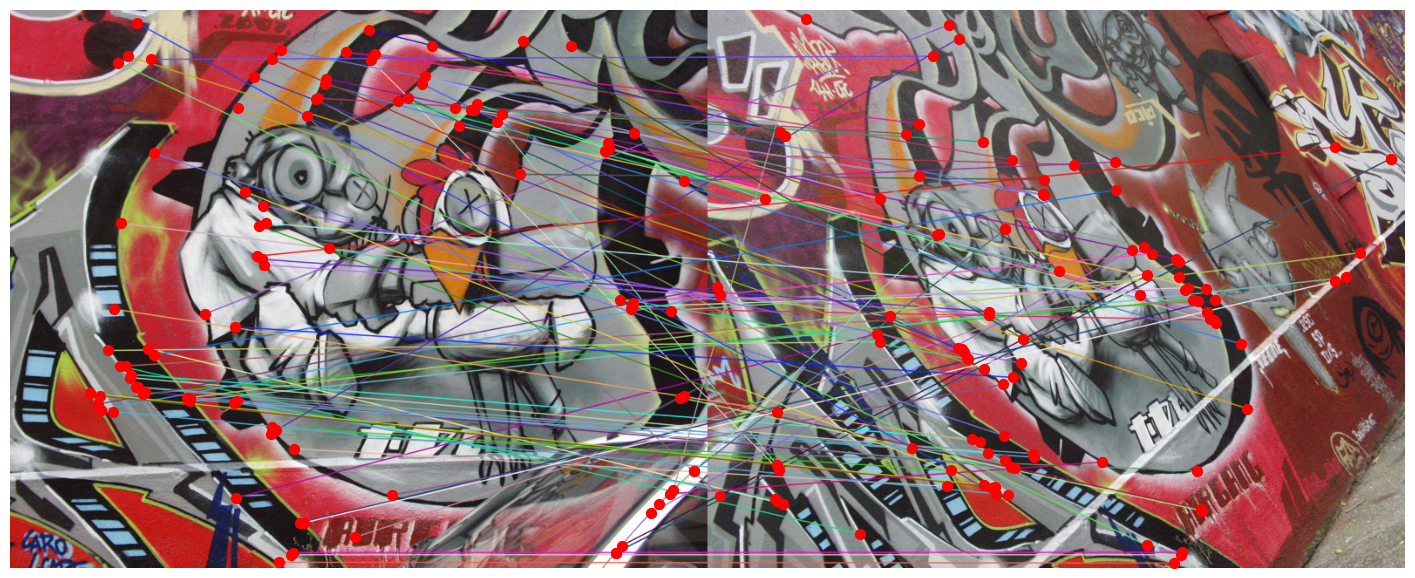

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

#read images
img1 = cv.imread(r"Pic\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"Pic\img4.ppm", cv.IMREAD_COLOR)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

#create SIFT object
sift = cv.SIFT_create(contrastThreshold=0.08,edgeThreshold =5,sigma = 0.5)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)#find keypoints
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
#match SIFT features
bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)
matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
#draw Matches
img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[0:100], None, flags =2)
fig, ax = plt.subplots(1,1, figsize = (18, 18))
plt.imshow(img3)

for i in range(0,100):
    plt.scatter(keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1], s=50, c='red', marker='o')
    plt.scatter(keypoints_2[matches[i].trainIdx].pt[0]+800, keypoints_2[matches[i].trainIdx].pt[1], s=50, c='red', marker='o')
plt.axis('off')
plt.show()

In [4]:
import cv2
import numpy as np
import getopt
import sys
import random
def calcHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        Source = np.matrix([corr.item(0), corr.item(1), 1])
        Traget = np.matrix([corr.item(2), corr.item(3), 1])
        row1 = [-Traget.item(2) *Source.item(0), -Traget.item(2) *Source.item(1), -Traget.item(2) *Source.item(2), 0, 0, 0,
              Traget.item(0) *Source.item(0), Traget.item(0) *Source.item(1), Traget.item(0) *Source.item(2)]
        row2 = [0, 0, 0, -Traget.item(2) *Source.item(0), -Traget.item(2) *Source.item(1), -Traget.item(2) *Source.item(2),
              Traget.item(1) *Source.item(0), Traget.item(1) *Source.item(1), Traget.item(1) *Source.item(2)]
        
        aList.append(row1)
        aList.append(row2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    Source = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimateTraget = np.dot(h,Source)
    estimateTraget = (1/estimateTraget.item(2))*estimateTraget

    Traget = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = Traget - estimateTraget
    return np.linalg.norm(error)



def ransac(corr, thresh):
    maxInliers = []
    
    for i in range(1000):
        rndPoints=np.random.choice(len(corr), size=4, replace=False)
        randomFour = np.array([corr[x] for x in rndPoints])
        #call the homography function 
        h = calcHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            homography_Matrix = h
        
        if len(maxInliers) > (len(corr)*thresh):
            break
    return homography_Matrix



In [5]:
import cv2 as cv
import numpy as np
import getopt
import sys
import random

def Homography_Mat(im1,im2):
      
    correspondpoints = []
    #read images
    img1 = cv.imread(im1,cv.IMREAD_ANYCOLOR)
    img2 = cv.imread(im2,cv.IMREAD_ANYCOLOR)
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    sift = cv.SIFT_create()#create SIFT object
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)#calculate keypoints and descriptors
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)
    matches = bf.match(descriptors_1, descriptors_2)#match sift features
    #find corosponding query & train image coordinate of matches
    for match in matches:
        (x1, y1) = keypoints_1[match.queryIdx].pt
        (x2, y2) = keypoints_2[match.trainIdx].pt
        correspondpoints.append([x1,y1,x2,y2])
    corrs = np.matrix(correspondpoints)

    #use ransac algorithm to calculate homography matrix
    finalH = ransac(corrs, 0.8)#my own ransac funtion
    return finalH

H1=Homography_Mat(r"Pic\img1.ppm",r"Pic\img2.ppm")
H2=Homography_Mat(r"Pic\img2.ppm",r"Pic\img3.ppm")
H3=Homography_Mat(r"Pic\img3.ppm",r"Pic\img4.ppm")
H4=Homography_Mat(r"Pic\img4.ppm",r"Pic\img5.ppm")
calculated_H1to5=H4@H3@H2@H1
given_H1to5  =np.array([[6.2544644e-01 ,  5.7759174e-02  , 2.2201217e+02],
   [2.2240536e-01 ,  1.1652147e+00 , -2.5605611e+01],
   [4.9212545e-04 , -3.6542424e-05  , 1.0000000e+00]])
diffrence=given_H1to5-calculated_H1to5
print(calculated_H1to5)
print(diffrence)

[[ 6.33781823e-01  1.02734063e-01  2.10035006e+02]
 [ 2.23507050e-01  1.19814134e+00 -3.10095706e+01]
 [ 5.01922585e-04  3.46441933e-05  9.89089417e-01]]
[[-8.33538308e-03 -4.49748886e-02  1.19771645e+01]
 [-1.10169007e-03 -3.29266422e-02  5.40395957e+00]
 [-9.79713482e-06 -7.11866173e-05  1.09105833e-02]]


In [6]:
np.sum(abs(calculated_H1to5-given_H1to5)**2)
s = np.sum(abs((calculated_H1to5-given_H1to5)**2))
s

0.3465142845260755

((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

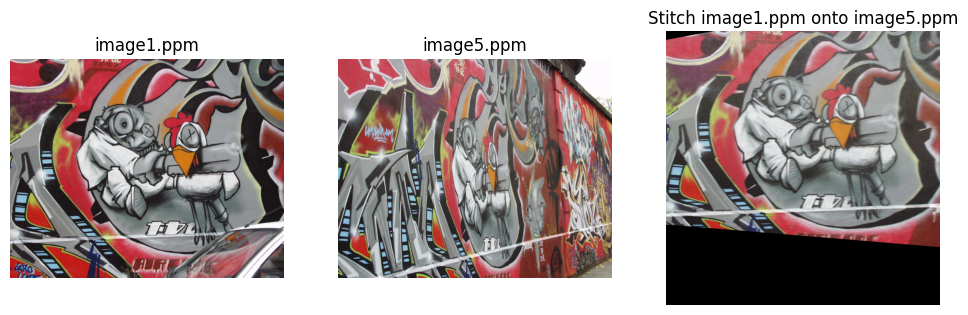

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image1 = cv.imread(r"./Pic/img1.ppm",cv.IMREAD_ANYCOLOR)
image2 = cv.imread(r"./Pic/img5.ppm",cv.IMREAD_ANYCOLOR)
image1=cv.cvtColor(image1,cv.COLOR_BGR2RGB)
image2=cv.cvtColor(image2,cv.COLOR_BGR2RGB)

H=H4@H3@H2@H1

imagelto4 = cv.warpPerspective(image2,np.linalg.inv(H),(800,800))


fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(image1)
ax[0].set_title("image1.ppm")
ax[1].imshow(image2)
ax[1].set_title("image5.ppm")
ax[2].imshow(imagelto4)
ax[2].set_title("Stitch image1.ppm onto image5.ppm")
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')